In [4]:
from EMsolver.solver import EMsolver
from RBG_Maxwell.Plasma.utils import find_largest_time_steps
from Particle_transport.main import pic_transport
import cupy
import numpy as np
from RBG_Maxwell.Unit_conversion.main import unit_conversion
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Flexible Unit conversion

In [5]:
# Unit conversion table
hbar, c, lambdax, epsilon0 = 1.1822579826363647e-07, 2.9979090484247153, 1.386275612896618e-15, 90631227428685.16
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# Initial variables

In [6]:
# Physical parameters
macro_particle = 0.05
charges = [-1.60217733e-19*conversion_table['Coulomb']*macro_particle] # unit in Coulomb
masses = [9.1093897e-31*conversion_table['kilogram']*macro_particle] # unit in kg
number_charges = [macro_particle]

# Grid initial
# Grid boundary
x_left_bound_o, y_left_bound_o, z_left_bound_o = 0, 0, 0 # Observation
x_left_bound_s, y_left_bound_s, z_left_bound_s = x_left_bound_o, y_left_bound_o, z_left_bound_o # Source

# Grid size
dx, dy, dz = 1e-5*conversion_table['meter'], 1e-5*conversion_table['meter'], 1e-5*conversion_table['meter']
dx_o, dy_o, dz_o = dx, dy, dz # Observation
dx_s, dy_s, dz_s = dx_o, dy_o, dz_o # Source

# Space size
nx, ny, nz = 1, 251, 111
x_grid_size_o, y_grid_size_o, z_grid_size_o = nx, ny, nz
x_grid_size_s, y_grid_size_s, z_grid_size_s = x_grid_size_o, y_grid_size_o, z_grid_size_o

# Computing time
total_comp_time = 1.0 * 1.0e-9*conversion_table['second'] # unit in second
n_step = 100
dt = total_comp_time/10000 # unit in second

# particle initial
initial_energy = 10 # electron velocity in unit of eV
initial_velocity = 1 * 3*10**8*np.sqrt(1 - (1 / (1 + initial_energy/510000)**2))*conversion_table['meter']/conversion_table['second'] # electron velocity in unit of m/s
total_charge = -0.5e-13 * conversion_table['Coulomb'] # unit in Coulomb
number_of_particles = int(total_charge/charges[0]) + 1 # Number of macro particles

# Set the positions of all the particles in x, y, and z axes separately
pos_x = (0 + 1 * np.random.random(number_of_particles)) * dx
pos_y = (124 + 1 * np.random.random(number_of_particles)) * dy
pos_z = (5 + 101 * np.random.random(number_of_particles)) * dz
pos = {0: np.array([pos_x, pos_y, pos_z]).transpose()} # Positions of all the particles

# Set the velocities of all the particles in x, y, and z axes separately
v_x = initial_velocity * np.ones(number_of_particles)
v_y = initial_velocity * np.ones(number_of_particles)
v_z = initial_velocity * np.ones(number_of_particles)
velocity = {0: np.array([v_x, v_y, v_z]).transpose()} # Velocities of all the particles

In [7]:
# set up the number of time snapshots to be saved
len_time_snapshots = min(find_largest_time_steps(dx_o, dy_o, dz_o, \
                                                 x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                                                 dx_s, dy_s, dz_s, \
                                                 x_left_bound_s, y_left_bound_s, z_left_bound_s, \
                                                 x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                                                 x_grid_size_s, y_grid_size_s, z_grid_size_s,\
                                                 dt, c), 10000)

# Initialize the code

In [8]:
# Initialize the partile transport module
PIC = pic_transport(pos, velocity, dt, charges, number_charges, masses, \
                    x_left_bound_o, y_left_bound_o, z_left_bound_o, nx, ny, nz, dx_s, dy_s, dz_s)

In [9]:
# Initialize the electromagnetic field Jefimenko's equations solver
PIC_provider = EMsolver(len_time_snapshots, \
                        x_grid_size_o, y_grid_size_o, z_grid_size_o, \
                        x_grid_size_s, y_grid_size_s, z_grid_size_s, \
                        dx_o, dy_o, dz_o, x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                        dx_s, dy_s, dz_s, x_left_bound_s, y_left_bound_s, z_left_bound_s, \
                        dt, epsilon0, c)

# Plasma evolution

In [10]:
n_steps = (n_step + 1) # total_comp_time_step
diagnose_point = 2 # Save the results up to 100 diagnosing points
print_point = n_steps//10 # Print the progress per 10%
# Create the diagnosing list
electron_rho = []
EMfield = []
current_rho = []
pos_save = []
velocity_save = []
num_rho = []

# Start the time
start_time = time.time()
print('The total time step is around {}'.format(n_steps))
for i_step in range(n_steps):
    
    ##########################################################################
    rho_to_Jefi, Jx_to_Jefi, Jy_to_Jefi, Jz_to_Jefi = PIC.evaluate_rho_J(dx, dy, dz, nx, ny, nz)
    ##########################################################################
   
    rho, Jx, Jy, Jz = rho_to_Jefi.flatten(), \
                      Jx_to_Jefi.flatten(), \
                      Jy_to_Jefi.flatten(), \
                      Jz_to_Jefi.flatten()
    
    PIC_provider.Jefimenko_solver(rho, Jx, Jy, Jz)
    
    # atrack EM fields
    Ex, Ey, Ez, Bx, By, Bz = PIC_provider.acquire_EB_field()

    # Add a external magnetic field
    By += 10*conversion_table['Tesla'] 

    # proceed particle transport
    PIC.proceed_one_step(Ex, Ey, Ez, Bx, By, Bz, dx, dy, dz, nx, ny, nz)
    
    if i_step%print_point == 0 or i_step == n_steps:
        print('calculating the {}-th time step'.format(i_step),', finished {}% '.format(100*(i_step+1)/n_steps))
    
    if i_step%diagnose_point == 0 or i_step == n_steps:       
        current_rho.append([Jx_to_Jefi.get(), Jy_to_Jefi.get(), Jz_to_Jefi.get()])
        electron_rho.append(rho_to_Jefi.get())
        for i_key in pos.keys():
            pos_save.append(PIC.pos[i_key].get())
            velocity_save.append(PIC.velocity[i_key].get())
        num_rho.append(PIC.evaluate_n_nu(dx, dy, dz, nx, ny, nz).get())
        EMfield.append([Ex.get(), Ey.get(), Ez.get(), Bx.get(), By.get(), Bz.get()])

# End the time
end_time = time.time()
t_time = end_time - start_time # Give the total computing time

The total time step is around 101
calculating the 0-th time step , finished 0.9900990099009901% 
calculating the 10-th time step , finished 10.891089108910892% 
calculating the 20-th time step , finished 20.792079207920793% 
calculating the 30-th time step , finished 30.693069306930692% 
calculating the 40-th time step , finished 40.59405940594059% 
calculating the 50-th time step , finished 50.495049504950494% 
calculating the 60-th time step , finished 60.396039603960396% 
calculating the 70-th time step , finished 70.29702970297029% 
calculating the 80-th time step , finished 80.1980198019802% 
calculating the 90-th time step , finished 90.0990099009901% 
calculating the 100-th time step , finished 100.0% 


In [11]:
t_time

255.17327690124512

# Data analysis

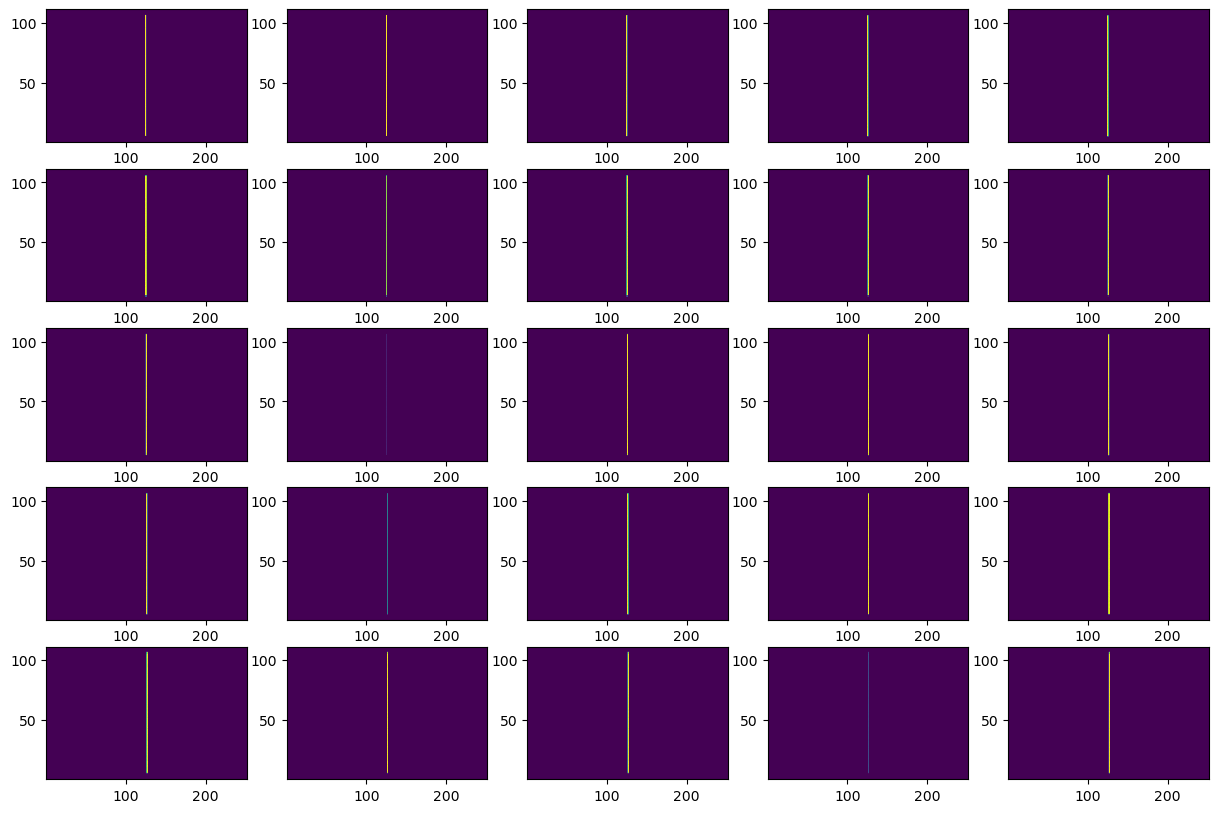

In [12]:
# spatial distribution
import matplotlib.pyplot as plt
%matplotlib inline
xi, yi = np.mgrid[1:252:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=5, figsize = (15,10))
for jj in range(5):
    for kk in range(5):  
        axes[jj,kk].pcolormesh(xi, yi, num_rho[jj*10+kk*2+2][0])